In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from six.moves import cPickle as pickle
%matplotlib inline

# Read the training data

In [19]:
#pickle_file = 'train.pickle'
'''
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_1 = save['data']
    train_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
'''
    
pickle_file = 'train2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_0 = save['data']
    train_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory
    
'''
pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_1 = save['data']
    test_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
    
'''

pickle_file = 'test2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_0 = save['data']
    test_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory

In [20]:
#reformat the label
#for each digit, add a 'end_digit' as '10'
#for each label, add a digit size
#each of them is a one-hot coding

def label_reformat(label, max_size = 5):
    digit_size = np.asarray([len(x) for x in label])
    digit_size[digit_size > max_size]= max_size
    digit_size = ((np.arange(max_size)+1) == digit_size[:,None]).astype(np.float32)
    
    digits = {}
    end_digit = 10.0
    for i in range(max_size):
        digit_coding = np.asarray( [x[i] if len(x)>i else end_digit for x in label])
        digit_coding = (np.arange(end_digit+1) == digit_coding[:,None]).astype(np.float32)
        digits['digit_'+ str(i)] = digit_coding
        
    return digit_size, digits   

# sample a smaller data

In [21]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

In [22]:
train_X_0.shape

(33402, 64, 64, 3)

In [23]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

image_size = train_X_0.shape[1]
num_channels = train_X_0.shape[3]
batch_size = 100
val_size = 50
test_size = 50


#train_label = train_outcome_1['label'] +  train_outcome_2['label']
train_label = train_outcome_0['label'][:400]
train_digit_size, train_digits = label_reformat(train_label)
train_X = train_X_0[:400]


val_label = test_outcome_0['label']
val_digit_size, val_digits = label_reformat(val_label)
val_X = test_X_0

val_size = val_X.shape[0]

In [24]:
print train_digit_size.shape
print train_digits['digit_0'].shape
print train_X.shape

(400, 5)
(400, 11)
(400, 64, 64, 3)


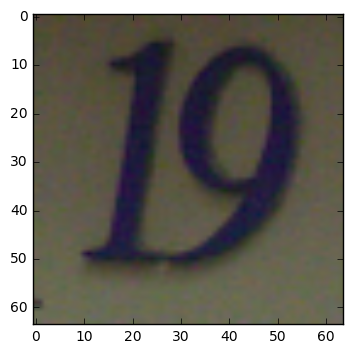

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [25]:
plt.imshow(train_X[0,:,:,:])
plt.show()
print train_digits['digit_0'][0]
print train_digits['digit_1'][0]

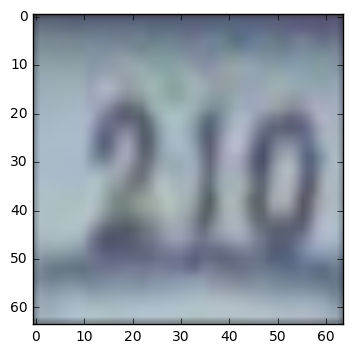

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [26]:
plt.imshow(val_X[1,:,:,:])
plt.show()
print val_digits['digit_0'][1]
print val_digits['digit_1'][1]

# start tensorflow session

In [27]:
def next_batch(X, y_dsize, y_ds, batch_size=50, replace = True):
    idx = np.random.choice(X.shape[0],batch_size, replace = replace)
    batch_x = X[idx,:,:,:]
    batch_y_dsize = y_dsize[idx,:]
    batch_y_d1 = y_ds['digit_0'][idx,:]
    batch_y_d2 = y_ds['digit_1'][idx,:]
    batch_y_d3 = y_ds['digit_2'][idx,:]
    batch_y_d4 = y_ds['digit_3'][idx,:]
    batch_y_d5 = y_ds['digit_4'][idx,:]
    
    return batch_x, batch_y_dsize, batch_y_d1, batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5


In [28]:
reg = 1e-4

graph = tf.Graph()
with graph.as_default():
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(1.0, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        return conv

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    def max_pool_2x2_same(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
    
    x_image = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))

    y_d1 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d2 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d3 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d4 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d5 = tf.placeholder(tf.float32, shape=(batch_size, 11))

    y_dsize = tf.placeholder(tf.float32, shape=(batch_size, 5))
    
    val_x_image = tf.placeholder(tf.float32, shape=(val_size, image_size, image_size, num_channels))

    val_y_d1 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d2 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d3 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d4 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d5 = tf.placeholder(tf.float32, shape=(val_size, 11))

    val_y_dsize = tf.placeholder(tf.float32, shape=(val_size, 5))

    test_x_image = tf.placeholder(tf.float32, shape=(test_size, image_size, image_size, num_channels))

    test_y_d1 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d2 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d3 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d4 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d5 = tf.placeholder(tf.float32, shape=(test_size, 11))

    test_y_dsize = tf.placeholder(tf.float32, shape=(test_size, 5))
    
    
    W_conv1 = weight_variable([5, 5, num_channels, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2_same(h_conv2)
    
    #W_fc1 = weight_variable([16 * 16 * 64, 1024])
    #b_fc1 = bias_variable([1024])

    #h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
    #h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    W_conv3 = weight_variable([5, 5, 64, 128])
    b_conv3 = bias_variable([128])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    
        
    W_conv4 = weight_variable([5, 5, 128, 160])
    b_conv4 = bias_variable([160])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2_same(h_conv4)
    
    
    W_conv5 = weight_variable([5, 5, 160, 180])
    b_conv5 = bias_variable([180])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2_same(h_conv5)
    
    
    W_conv6 = weight_variable([5, 5, 180, 180])
    b_conv6 = bias_variable([180])

    h_conv6 = tf.nn.relu(conv2d(h_pool5, W_conv6) + b_conv6)
    h_pool6 = max_pool_2x2_same(h_conv6)
    
    

    W_fc1 = weight_variable([16 * 16 * 180, 1024])
    b_fc1 = bias_variable([1024])

    h_pool6_flat = tf.reshape(h_pool6, [-1, 16*16*180])
    z_fc1 = tf.matmul(h_pool6_flat, W_fc1) + b_fc1
    h_fc1 = tf.nn.relu(z_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    
    #first digit
    W_fc2_d1 = weight_variable([1024, 11])
    b_fc2_d1 = bias_variable([11])

    y_conv_d1 = tf.matmul(h_fc1_drop, W_fc2_d1) + b_fc2_d1

    #second digit
    W_fc2_d2 = weight_variable([1024, 11])
    b_fc2_d2 = bias_variable([11])

    y_conv_d2 = tf.matmul(h_fc1_drop, W_fc2_d2) + b_fc2_d2

    #third digit
    W_fc2_d3 = weight_variable([1024, 11])
    b_fc2_d3 = bias_variable([11])

    y_conv_d3 = tf.matmul(h_fc1_drop, W_fc2_d3) + b_fc2_d3

    #fourth digit
    W_fc2_d4 = weight_variable([1024, 11])
    b_fc2_d4 = bias_variable([11])

    y_conv_d4 = tf.matmul(h_fc1_drop, W_fc2_d4) + b_fc2_d4

    #fifth digit
    W_fc2_d5 = weight_variable([1024, 11])
    b_fc2_d5 = bias_variable([11])

    y_conv_d5 = tf.matmul(h_fc1_drop, W_fc2_d5) + b_fc2_d5

    #digit size
    W_fc2_dsize = weight_variable([1024, 5])
    b_fc2_dsize = bias_variable([5])

    y_conv_dsize = tf.matmul(h_fc1_drop, W_fc2_dsize) + b_fc2_dsize

    
    cross_entropy = ( tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d1, y_d1)) 
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d2, y_d2))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d3, y_d3))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d4, y_d4))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d5, y_d5))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_dsize, y_dsize))
                     ) + reg *(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) 
                               + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4) 
                               + tf.nn.l2_loss(W_fc1)
                               + tf.nn.l2_loss(W_fc2_d1) + tf.nn.l2_loss(W_fc2_d2) 
                               + tf.nn.l2_loss(W_fc2_d3) + tf.nn.l2_loss(W_fc2_d4) 
                               + tf.nn.l2_loss(W_fc2_d5) + tf.nn.l2_loss(W_fc2_dsize) 
                              ) 

    train_step = tf.train.AdamOptimizer(1e-2,epsilon=0.1).minimize(cross_entropy)
    #train_step = tf.train.tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
    
    #let's just check the first digit
    correct_prediction = tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

# Train model on a small data, see whether it overfit 
if overfit, then good. If not, check bugs.

In [36]:
num_steps = 5000
summary_frequency = 20

BNs_train, BNs_test, acc_train, acc_test = [], [], [], []

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')

    for i in range(num_steps):
        (batch_x, batch_y_dsize, 
         batch_y_d1, batch_y_d2, 
         batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(train_X, 
                                                          train_digit_size, 
                                                          train_digits, batch_size)
        feed_dict={
                x_image: batch_x, y_dsize: batch_y_dsize,
                y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
                y_d4: batch_y_d4, y_d5: batch_y_d5,
                keep_prob: 0.5}
        
        session.run(train_step,feed_dict=feed_dict)
    
        if i%summary_frequency == 0:
            res_train = session.run([accuracy,z_fc1],feed_dict=feed_dict)
            print("step %d, training accuracy %g"%(i, res_train[0]))
            
            acc_train.append(res_train[0])
            BNs_train.append(np.mean(res_train[1],axis=0).flatten()[:10])
            
            (batch_x, batch_y_dsize, batch_y_d1,
             batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, 
                                                                          val_digit_size, 
                                                                          val_digits, 
                                                                          batch_size, replace = False)
            feed_dict={x_image: batch_x, 
                       y_dsize: batch_y_dsize,y_d1: batch_y_d1, 
                       y_d2: batch_y_d2, y_d3: batch_y_d3,y_d4: batch_y_d4, 
                       y_d5: batch_y_d5, keep_prob: 1}
        
            res = session.run([accuracy,z_fc1],feed_dict=feed_dict)

            acc_test.append(res[0])

            # record the first 10 mean value of BN2 over the entire test set
            BNs_test.append(np.mean(res[1],axis=0).flatten()[:10])
            print("step %d, val accuracy %g"%(i, res[0]))
        
BNs_train, BNs_test, acc_train, acc_test = ( np.array(BNs_train), 
                                            np.array(BNs_test), 
                                            np.array(acc_train), 
                                            np.array(acc_test) )



Initialized
step 0, training accuracy 0.25
step 0, val accuracy 0.3
step 20, training accuracy 0.35
step 20, val accuracy 0.24
step 40, training accuracy 0.25
step 40, val accuracy 0.31
step 60, training accuracy 0.33
step 60, val accuracy 0.35
step 80, training accuracy 0.3
step 80, val accuracy 0.28
step 100, training accuracy 0.33
step 100, val accuracy 0.26
step 120, training accuracy 0.32
step 120, val accuracy 0.25
step 140, training accuracy 0.24
step 140, val accuracy 0.2
step 160, training accuracy 0.25
step 160, val accuracy 0.31
step 180, training accuracy 0.25
step 180, val accuracy 0.26
step 200, training accuracy 0.26
step 200, val accuracy 0.35
step 220, training accuracy 0.29
step 220, val accuracy 0.31
step 240, training accuracy 0.29
step 240, val accuracy 0.21
step 260, training accuracy 0.41
step 260, val accuracy 0.3
step 280, training accuracy 0.32
step 280, val accuracy 0.31
step 300, training accuracy 0.32
step 300, val accuracy 0.32
step 320, training accuracy 

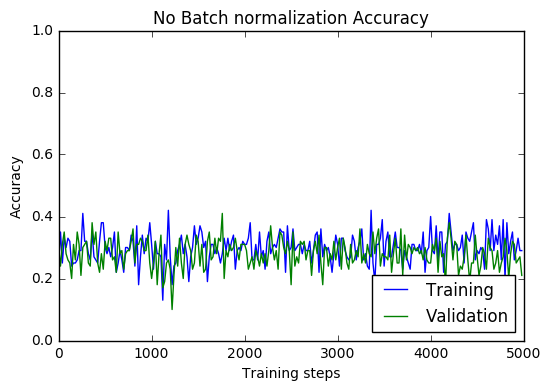

In [39]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc_train)*summary_frequency,summary_frequency),acc_train, label='Training')
ax.plot(range(0,len(acc_test)*summary_frequency,summary_frequency),acc_test, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('No Batch normalization Accuracy')
ax.legend(loc=4)
plt.show()

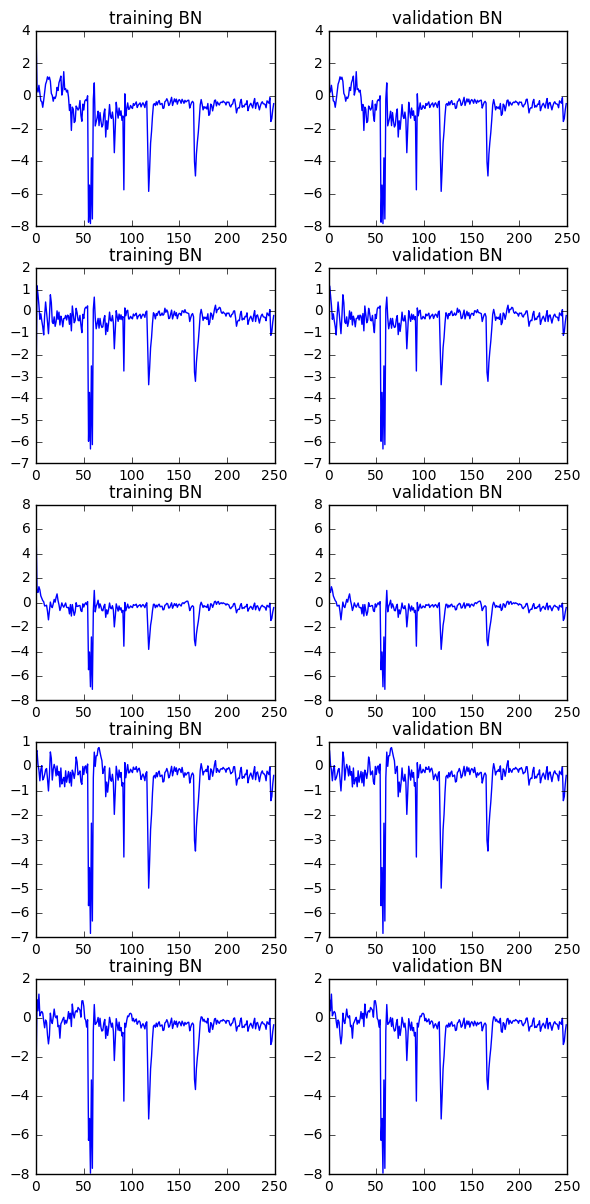

In [40]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("training BN")
    ax[1].set_title("validation BN")
    ax[0].plot(BNs_train[:,i])
    ax[1].plot(BNs_test[:,i])